In [1]:
!pip install tensorflow keras keras-tuner scikeras
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow. keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_tuner.tuners import RandomSearch
import keras_tuner as kt
from scikeras.wrappers import KerasClassifier


In [3]:
import torch

# Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [10]:
#load data
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from google.colab import files
import zipfile
# === Step 1: Load CSVs ===

zip_path = "drive/MyDrive/lstm_data.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("lstm_data")

train_df = pd.read_csv("lstm_data/train.csv")
val_df = pd.read_csv("lstm_data/val.csv")
test_df = pd.read_csv("lstm_data/test.csv")

In [11]:
train_df.head()

,text,stars,sentiment,clean_text,tokens,input_ids,label
0,"Let me start by saying the chicken is good, no...",3,1,let start say chicken good great lot variety g...,"['let', 'start', 'say', 'chicken', 'good', 'gr...","[167, 127, 30, 21, 4, 9, 81, 419, 4, 766, 255,...",1
1,I hate to make an update to a restaurant that ...,3,1,hate update restaurant star previous experienc...,"['hate', 'update', 'restaurant', 'star', 'prev...","[669, 690, 15, 59, 890, 43, 2, 234, 2, 9, 43, ...",1
2,If i could give it a - i would. Waited 20 minu...,1,0,wait minute beer cocktail send water take minu...,"['wait', 'minute', 'beer', 'cocktail', 'send',...","[17, 34, 79, 357, 443, 153, 37, 34, 3, 23, 8, ...",0
3,"It was good, not great. Good location. Recepti...",3,1,good great good location receptionist helpful ...,"['good', 'great', 'good', 'location', 'recepti...","[4, 9, 4, 88, 3998, 409, 98, 2, 12167, 1642]",1
4,Wish I could give this shop a better grade.......,3,1,wish shop well gradethe staff friendly avail f...,"['wish', 'shop', 'well', 'gradethe', 'staff', ...","[274, 416, 36, 40082, 35, 55, 4105, 228, 382, ...",1


In [12]:


# === Step 2: Extract features (X) and labels (y) ===
X_train_raw = train_df['clean_text'].astype(str)
y_train = train_df['label']

X_val_raw = val_df['clean_text'].astype(str)
y_val = val_df['label']

X_test_raw = test_df['clean_text'].astype(str)
y_test = test_df['label']

# === Step 3: Tokenize and pad sequences ===
vocab_size = 10000
max_len = 150

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_raw), maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_raw), maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_raw), maxlen=max_len, padding='post', truncating='post')


In [13]:
# === Calculate class weights ===
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.8861074199494192), 1: np.float64(1.3460962427557466), 2: np.float64(0.886069438491213)}


In [14]:
# === Model Builder for Keras Tuner ===
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=10000,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=150
    ))
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3-class classification

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 3e-4, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [15]:
# Create a folder to save checkpoints
checkpoint_dir = "checkpoints_lstm_tuning"
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint to save best model each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_epoch_{epoch:02d}.h5"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [16]:
# === Keras Tuner Setup ===
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='lstm_text_classifier'
)


# === Early stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# === Search Best Hyperparameters ===
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val),
             batch_size=32,
             class_weight=class_weights,
             callbacks=[early_stop])

Trial 5 Complete [00h 03m 25s]
val_accuracy: 0.7982456088066101

Best val_accuracy So Far: 0.8334623575210571
Total elapsed time: 00h 16m 44s


In [17]:
# Retrieve and build best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)


In [18]:
import os
print(os.listdir())


['.config', 'drive', 'tuner_dir', 'checkpoints_lstm_tuning', 'lstm_data', 'sample_data']


In [19]:
import pickle

# === Re-train best_model to get training history ===
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# === Save model (.h5) ===
best_model.save("best_lstm_model.h5")

# === Save training history ===
with open("history_log.pkl", "wb") as f:
    pickle.dump(history.history, f)



Epoch 1/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.3409 - loss: 1.0994 - val_accuracy: 0.2481 - val_loss: 1.1138
Epoch 2/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.3522 - loss: 1.0900 - val_accuracy: 0.3971 - val_loss: 1.0900
Epoch 3/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5554 - loss: 0.9004 - val_accuracy: 0.7674 - val_loss: 0.5474
Epoch 4/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8078 - loss: 0.4940 - val_accuracy: 0.7961 - val_loss: 0.5033
Epoch 5/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8688 - loss: 0.3605 - val_accuracy: 0.8159 - val_loss: 0.4765
Epoch 6/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9101 - loss: 0.2616 - val_accuracy: 0.8304 - val_loss: 0.4892
Epoch 7/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9385 - loss: 0.1917 - val_accuracy: 0.8340 - val_loss: 0.5290
Epoch 8/10
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9575 -

In [20]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8324 - loss: 0.4525
Test Accuracy: 0.8305
Test Loss: 0.4488


In [21]:
results = {"test_accuracy": test_accuracy, "test_loss": test_loss}
with open("test_results.pkl", "wb") as f:
    pickle.dump(results, f)


Accuracy/Loss plots

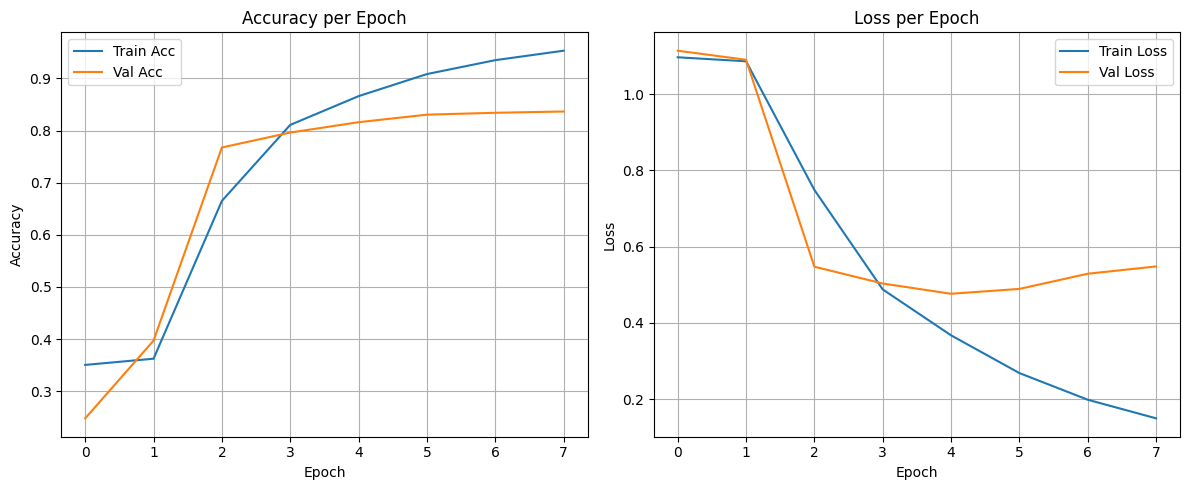

In [22]:
import matplotlib.pyplot as plt
import pickle

# Load history if needed
with open("history_log.pkl", "rb") as f:
    history_dict = pickle.load(f)

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Acc')
plt.plot(history_dict['val_accuracy'], label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Confusion matrix and classification report

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


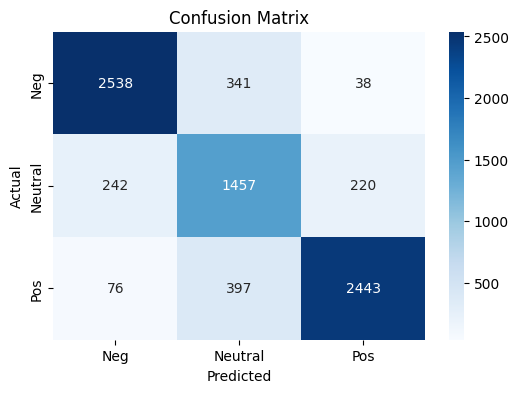

Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      2917
     Neutral       0.66      0.76      0.71      1919
    Positive       0.90      0.84      0.87      2916

    accuracy                           0.83      7752
   macro avg       0.82      0.82      0.82      7752
weighted avg       0.84      0.83      0.83      7752



In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred = best_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neutral', 'Pos'], yticklabels=['Neg', 'Neutral', 'Pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))


**ADD OTHER VISUALIZATION CODE BELOW**

In [24]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences


Confidence Calibration Curve

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


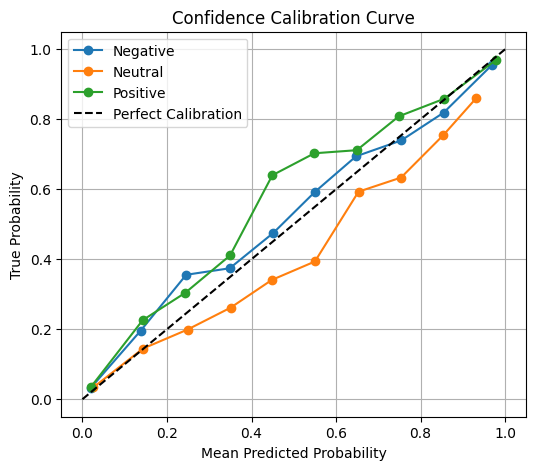

In [25]:
def plot_confidence_calibration(y_true, y_probs):
    plt.figure(figsize=(6, 5))
    for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
        prob_true, prob_pred = calibration_curve((np.array(y_true) == i).astype(int), y_probs[:, i], n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=f"{label}")
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("True Probability")
    plt.title("Confidence Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run
y_probs = best_model.predict(X_test)
plot_confidence_calibration(y_test, y_probs)


Misclassified samples reviewed

In [26]:
from pandas import DataFrame

y_pred = np.argmax(y_probs, axis=1)
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"🔍 Total Misclassified Samples: {len(misclassified_indices)}")

# Optional: print a few misclassified samples
for i in misclassified_indices[:5]:
    print("\n--- Sample ---")
    print("Text:", X_test[i])
    print("True Label:", ['Negative', 'Neutral', 'Positive'][y_test[i]])
    print("Predicted Label:", ['Negative', 'Neutral', 'Positive'][y_pred[i]])


🔍 Total Misclassified Samples: 1314

--- Sample ---
Text: [  27    5    8   68  188    1 6439   86  100  124  275   37  673  135
   24  174  190 1658   24  135  269  809  260    7   95    1  619 3305
   24  231  261  465  538  231 1460   66 3170  201    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
True Label: Negative
Predicted Label: Neutral

--- Sample ---
Text: [ 521  210  244    4 9210   49 3483 4013 1092 6010 1375  505  174   44
   80    3   80   79 3032   48   29  160 

ROC-AUC for 3 classes

In [27]:
# Binarize labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Compute AUC per class
for i, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
    auc = roc_auc_score(y_test_bin[:, i], y_probs[:, i])
    print(f"📊 ROC-AUC for {class_name}: {auc:.4f}")


📊 ROC-AUC for Negative: 0.9638
📊 ROC-AUC for Neutral: 0.8970
📊 ROC-AUC for Positive: 0.9626


Tested with prediction & confidence scores

In [28]:
real_reviews = [
    "Food was okay, nothing special.",
    "Terrible service and rude staff.",
    "This place was amazing, great vibes!"
]

real_seq = tokenizer.texts_to_sequences(real_reviews)
real_pad = pad_sequences(real_seq, maxlen=150, padding='post', truncating='post')

real_probs = best_model.predict(real_pad)
real_preds = np.argmax(real_probs, axis=1)

for text, pred, conf in zip(real_reviews, real_preds, real_probs.max(axis=1)):
    label = ['Negative', 'Neutral', 'Positive'][pred]
    print(f"Text: {text}\nPrediction: {label}\nConfidence: {conf:.4f}\n{'-'*40}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Text: Food was okay, nothing special.
Prediction: Neutral
Confidence: 0.6353
----------------------------------------
Text: Terrible service and rude staff.
Prediction: Negative
Confidence: 0.9739
----------------------------------------
Text: This place was amazing, great vibes!
Prediction: Positive
Confidence: 0.9298
----------------------------------------


Samples reviewd

In [29]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define test reviews
test_reviews = [
    # Positive
    "Absolutely fantastic! The pasta was perfectly cooked, and the wine selection was great.",
    "The server was friendly and attentive. Will definitely return!",
    "Loved the cozy vibe and the homemade desserts. A hidden gem!",
    "Quick service, fresh ingredients, and fair prices. What more could you ask for?",
    "Hands down the best ramen I’ve had in the city. Broth was rich and flavorful.",

    # Neutral
    "It was okay. Not the best I've had, but not terrible either.",
    "Average experience. Food was fine, service was standard.",
    "Decent place for lunch if you're nearby, but I wouldn't go out of my way.",
    "Ambience was nice, but the food didn’t stand out.",
    "Mixed feelings. Some dishes were good, others were bland.",

    # Negative
    "Terrible service. Waited 40 minutes just to place an order.",
    "Food was cold, overpriced, and the portions were tiny.",
    "The place smelled weird and the table was sticky.",
    "We got the wrong order and no apology from staff.",
    "Nothing tasted fresh. Left hungry and disappointed."
]

# Tokenize and pad the input
review_seq = tokenizer.texts_to_sequences(test_reviews)
review_pad = pad_sequences(review_seq, maxlen=150, padding='post', truncating='post')

# Predict
pred_probs = best_model.predict(review_pad)
pred_classes = np.argmax(pred_probs, axis=1)
labels = ['Negative', 'Neutral', 'Positive']

# Display results
for review, pred, prob in zip(test_reviews, pred_classes, pred_probs):
    confidence = np.max(prob)
    print(f"📝 Text: {review}")
    print(f"📌 Prediction: {labels[pred]}")
    print(f"📊 Confidence: {confidence:.4f}")
    print("-" * 60)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📝 Text: Absolutely fantastic! The pasta was perfectly cooked, and the wine selection was great.
📌 Prediction: Positive
📊 Confidence: 0.9891
------------------------------------------------------------
📝 Text: The server was friendly and attentive. Will definitely return!
📌 Prediction: Positive
📊 Confidence: 0.5808
------------------------------------------------------------
📝 Text: Loved the cozy vibe and the homemade desserts. A hidden gem!
📌 Prediction: Positive
📊 Confidence: 0.9587
------------------------------------------------------------
📝 Text: Quick service, fresh ingredients, and fair prices. What more could you ask for?
📌 Prediction: Positive
📊 Confidence: 0.7501
------------------------------------------------------------
📝 Text: Hands down the best ramen I’ve had in the city. Broth was rich and flavorful.
📌 Prediction: Positive
📊 Confidence: 0.9564
------------------------------------------------------------
📝 Text: It was okay. Not th

In [30]:
import shutil
from zipfile import ZipFile
from google.colab import files  # Remove this line if not using Colab

# === Step 1: Save all important paths ===
paths_to_download = [
    "best_lstm_model.h5",
    "tokenizer.pkl",
    "history_log.pkl",
    "checkpoints_lstm_tuning",
    # "kt_logs"  # Optional: tuner logs if needed
]

# === Step 2: Create zip archive ===
archive_name = "lstm_model_bundle.zip"

with ZipFile(archive_name, 'w') as zipf:
    for path in paths_to_download:
        if os.path.isfile(path):
            zipf.write(path)
        elif os.path.isdir(path):
            shutil.make_archive(path, 'zip', path)
            zipf.write(path + ".zip")

print(f"✅ Files bundled into: {archive_name}")


✅ Files bundled into: lstm_model_bundle.zip


In [31]:
# Download ZIP to your machine
files.download("lstm_model_bundle.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#!pip install gradio --quiet


In [ ]:
#import pickle

# Save tokenizer
#with open("tokenizer.pkl", "wb") as f:
    #pickle.dump(tokenizer, f)


In [ ]:
#import tensorflow as tf
#import pickle
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#import numpy as np

# Load trained model
#model = tf.keras.models.load_model("best_lstm_model.h5")

# Load tokenizer
#with open("tokenizer.pkl", "rb") as f:
    #tokenizer = pickle.load(f)

# Constants
#MAX_LEN = 150
#labels = ['Negative', 'Neutral', 'Positive']


In [ ]:
#def predict_sentiment(text):
    #if not text.strip():
        #return "Invalid input", "N/A"

    # Preprocessing
    #sequence = tokenizer.texts_to_sequences([text])
    #padded = pad_sequences(sequence, maxlen=150, padding='post', truncating='post')

    # Model prediction
    #probs = model.predict(padded)
    #if probs.shape[-1] != 3:
        #return "Invalid prediction", "N/A"

    #pred = np.argmax(probs, axis=1)[0]
    #confidence = float(np.max(probs))

    #label = ['Negative', 'Neutral', 'Positive'][pred]
    #return label, f"{confidence:.2f}"


In [ ]:
#import gradio as gr

#interface = gr.Interface(
    #fn=predict_sentiment,
    #inputs=gr.Textbox(lines=4, placeholder="Enter a Yelp-style review..."),
    #outputs=[
        #gr.Textbox(label="Predicted Sentiment"),
        #gr.Textbox(label="Confidence Score")
    #],
    #title="LSTM Yelp Review Classifier",
    #description="Enter a customer review and get the predicted sentiment (Negative, Neutral, Positive)."
#)

#interface.launch(share=True)  # Use share=True to get a public link


Word Importance Visualization using LIME-style

In [33]:
!pip install lime --quiet
from lime.lime_text import LimeTextExplainer

class_names = ['Negative', 'Neutral', 'Positive']
explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=150, padding='post', truncating='post')
    preds = best_model.predict(padded)
    return preds

# Pick an example
idx = 15  # pick any index from X_test_raw
explanation = explainer.explain_instance(X_test_raw.iloc[idx], predict_proba, num_features=10)
explanation.show_in_notebook(text=True)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Vocabulary influence shown via Top Words per Class

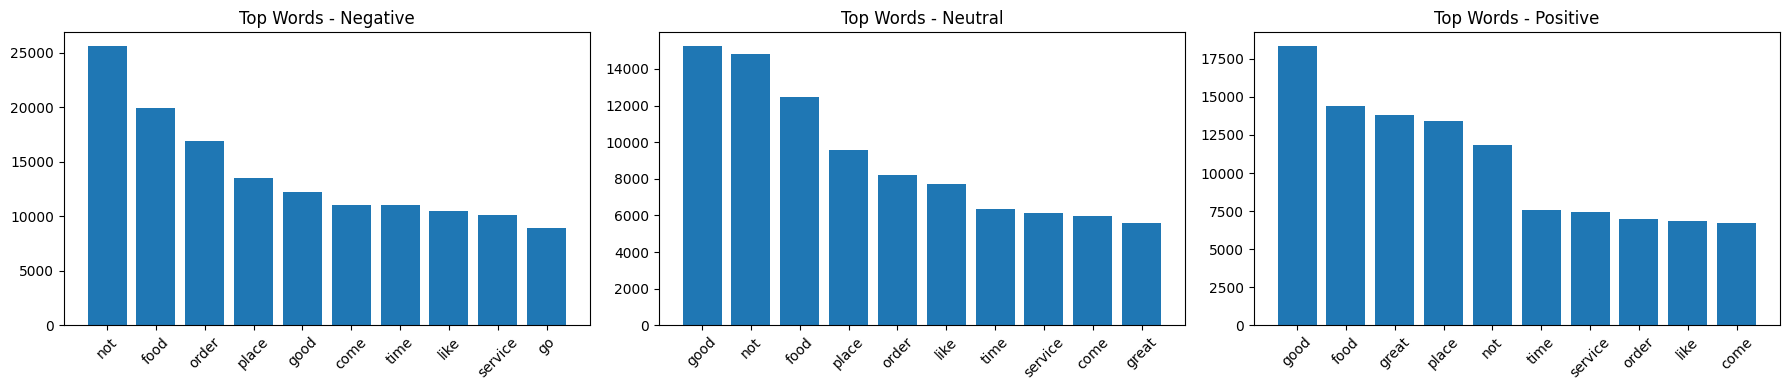

In [34]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Collect top words per class
top_words = defaultdict(Counter)
for text, label in zip(X_train_raw, y_train):
    for word in text.lower().split():
        top_words[label][word] += 1

# Plot top 10 for each class
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for cls in range(3):
    most_common = top_words[cls].most_common(10)
    words, counts = zip(*most_common)
    axes[cls].bar(words, counts)
    axes[cls].set_title(f"Top Words - {labels[cls]}")
    axes[cls].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Performance on Short vs. Long Reviews

In [36]:
import pandas as pd

lengths = X_test_raw.apply(lambda x: len(x.split()))
buckets = pd.cut(lengths, bins=[0, 25, 50, 100, 1000], labels=['Short', 'Medium', 'Long', 'Very Long'])

from sklearn.metrics import accuracy_score, f1_score

for bucket in buckets.unique():
    idxs = (buckets == bucket)
    X_sub = X_test[idxs]
    y_sub = y_test[idxs]
    if len(y_sub) == 0:
        continue
    y_pred = best_model.predict(X_sub)
    y_pred_labels = np.argmax(y_pred, axis=1)
    print(f"\n📏 {bucket} Reviews:")
    print("Accuracy:", accuracy_score(y_sub, y_pred_labels))
    print("F1 Score:", f1_score(y_sub, y_pred_labels, average='weighted'))


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

📏 Short Reviews:
Accuracy: 0.8240981777612495
F1 Score: 0.8251205899727861
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

📏 Medium Reviews:
Accuracy: 0.836039603960396
F1 Score: 0.8386913606554589
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📏 Long Reviews:
Accuracy: 0.8332419089413056
F1 Score: 0.8379032984766893
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📏 Very Long Reviews:
Accuracy: 0.827972027972028
F1 Score: 0.8273433890459588
